<a href="https://colab.research.google.com/github/kai-franz/harmony-solver/blob/main/harmony_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Set up music21 for Colab

Click the play button below to upgrade music21 and install MuseScore to use in Google Colab

In [7]:
!pip install --upgrade music21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/mscore-ubuntu/mscore-stable/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,519 kB]
Get:14 http://ppa.l

In [9]:
!apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 26 not upgraded.


In [10]:
from music21 import *
us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

# music21 is Open Source under the BSD License
# Copyright (c) 2006-22 Michael Scott Asato Cuthbert and cuthbertLab
# Support music21 by citing it in your research or produts:
#
#     Cuthbert, Michael Scott.  
#     _music21: a Toolkit for Computer-Aided Music Research_
#     https://web.mit.edu/music21
#     2006-22

## Setup z3

In [11]:
!pip install --upgrade z3-solver

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 MB 6.3 MB/s eta 0:00:00


## Harmony Solving

### Library

In [12]:
from dataclasses import dataclass

import z3

# Use midi value to represent
PitchMidiVarRef = z3.ArithRef
PitchMidiValue = int
# 0-11?
PitchClassVarRef = z3.ArithRef
PitchClassValue = int


@dataclass
class PitchVarRef:
    midi: PitchMidiVarRef
    pitchClass: PitchClassVarRef


@dataclass
class ChordVarRef:
    pitches: list[PitchVarRef]

    def soprano(self):
        return self.pitches[0]

    def alto(self):
        return self.pitches[1]

    def tenor(self):
        return self.pitches[2]

    def bass(self):
        return self.pitches[3]



@dataclass
class StreamVarRef:
    pitches: list[PitchVarRef]


def PitchVar(name: str) -> PitchVarRef:
    return PitchVarRef(z3.Int(f"{name}.pitchMidi"), z3.Int(f"{name}.pitchClass"))


def PitchMidiVar(name: str) -> PitchMidiVarRef:
    return z3.Int(f"{name}.pitchMidi")


def PitchClassVar(name: str) -> PitchClassVarRef:
    return z3.Int(f"{name}.pitchClass")


def StreamVar(var_names: list[str]) -> StreamVarRef:
    return StreamVarRef([PitchVar(name) for name in var_names])


def ChordVar(var_names: list[str]) -> ChordVarRef:
    return ChordVarRef([PitchVar(name) for name in var_names])

In [ ]:
from music21.pitch import Pitch

# Constraints
def PitchMidiEq(pitch_var: PitchVarRef, name: str):
    return pitch_var.midi == Pitch(name).midi

def PitchClassEq(pitch_var: PitchVarRef, pitch: Pitch):
    return pitch_var.pitchClass == pitch.pitchClass

def PitchRange(pitch_var: PitchVarRef, low, high, soft=False):
    # TODO(yuchen): Add option for soft check (M2 off)
    return z3.And(Pitch(low).midi <= pitch_var.midi, pitch_var.midi <= Pitch(high).midi)


def SopranoRange(pitch_var: PitchVarRef):
    return PitchRange(pitch_var, "C4", "G5")


def AltoRange(pitch_var: PitchVarRef):
    return PitchRange(pitch_var, "G3", "D5")


def TenorRange(pitch_var: PitchVarRef):
    return PitchRange(pitch_var, "C3", "G4")


def BassRange(pitch_var: PitchVarRef):
    return PitchRange(pitch_var, "E2", "D4")

In [ ]:
from music21.key import Key
from music21.roman import RomanNumeral
import music21.roman
from music21.chord import Chord
import music21.chord
import music21.interval
import itertools as it

PITCH_CLASSES_COUNT = 12

def PitchClassMidiRelation(pitch_var: PitchVarRef):
    return pitch_var.midi % PITCH_CLASSES_COUNT == pitch_var.pitchClass

def ChordEqRoman(chord_var: ChordVarRef, key: str, roman: str):
    chord = RomanNumeral(roman, key)
    bass = PitchClassEq(chord_var.bass(), chord.bass())
    all_chord_tones = z3.And([z3.Or([pitch_var.pitchClass == pitchClass for pitchClass in chord.pitchClasses]) for pitch_var in chord_var.pitches])
    complete_chord = z3.And([z3.Or([pitch_var.pitchClass == pitchClass for pitch_var in chord_var.pitches]) for pitchClass in chord.pitchClasses])
    return z3.And(bass, all_chord_tones, complete_chord)

def NoVoiceOverlap(chord_var: ChordVarRef):
    s, a, t, b = chord_var.pitches
    return z3.And([b.midi <= t.midi, t.midi <= a.midi, a.midi <= s.midi])

def NoVoiceCrossing(first: ChordVarRef, second: ChordVarRef):
    s0, a0, t0, b0 = first.pitches
    s1, a1, t1, b1 = second.pitches
    return z3.And(b1.midi <= t0.midi, 
                  b0.midi <= t1.midi, t1.midi <= a0.midi,
                  t0.midi <= a1.midi, a1.midi <= s0.midi,
                  a0.midi <= s1.midi
                  )

def VoicesWithinInterval(upper: StreamVarRef, lower: StreamVarRef, interv: str):
    interv = interval.Interval(interv)
    return z3.And([ u.midi - l.midi <= interv.semitones for u, l in zip(upper.pitches, lower.pitches)])


def Abs(var):
    return z3.If(var >= 0, var, -var)

def NoParallelFifth(first: ChordVarRef, second: ChordVarRef):
    first_diffs = [Abs(a.midi - b.midi) % PITCH_CLASSES_COUNT for a, b in it.combinations(first.pitches, 2)]
    second_diffs = [Abs(a.midi - b.midi) for a, b in it.combinations(second.pitches, 2)]
    P5 = interval.Interval('P5')
    d5 = interval.Interval('d5')
    # TODO: bass ^2 to ^3 d5 -> P5 OK
    return z3.And([
        z3.Not(z3.And(
            z3.Or(f == d5.semitones, f == P5.semitones), 
            s == P5.semitones)) 
        for f, s in zip(first_diffs, second_diffs)])


def NoParallelOctave(first: ChordVarRef, second: ChordVarRef):
    first_diffs = [Abs(a.midi - b.midi) for a, b in it.combinations(first.pitches, 2)]
    second_diffs = [Abs(a.midi - b.midi) for a, b in it.combinations(second.pitches, 2)]
    P8 = interval.Interval('P8')
    return z3.And([
        z3.Not(z3.And(
            f == P8.semitones, 
            s == P8.semitones)) 
        for f, s in zip(first_diffs, second_diffs)])

def DoubleRoot(chord_var: ChordVarRef, key: str, roman: str):
    chord = RomanNumeral(roman, key)
    root = chord.root()
    use_root_conditions = [z3.If(PitchClassEq(pitch_var, root), 1, 0) for pitch_var in chord_var.pitches]
    return sum(use_root_conditions) == 2

def DoubleBass(chord_var: ChordVarRef, key: str, roman: str):
    chord = RomanNumeral(roman, key)
    bass = chord.bass()
    use_bass_conditions = [z3.If(PitchClassEq(pitch_var, bass), 1, 0) for pitch_var in chord_var.pitches]
    return sum(use_bass_conditions) == 2

def DoubleThird(chord_var: ChordVarRef, key: str, roman: str):
    chord = RomanNumeral(roman, key)
    third = chord.third
    use_third_conditions = [z3.If(PitchClassEq(pitch_var, third), 1, 0) for pitch_var in chord_var.pitches]
    return sum(use_third_conditions) == 2

def SmoothVoice(stream_var: StreamVarRef, interv: str):
    interv = interval.Interval(interv)
    return z3.And([Abs(a.midi-b.midi) <= interv.semitones for a, b in zip(stream_var.pitches, stream_var.pitches[1:])])

def FourPartRange(part_streams):
    s, a, t, b = part_streams
    return z3.And(
        z3.And([SopranoRange(p) for p in s.pitches]), 
        z3.And([AltoRange(p) for p in a.pitches]),
        z3.And([TenorRange(p) for p in t.pitches]),
        z3.And([BassRange(p) for p in b.pitches]),
)


### Demo

====== Model ======

====== Demo ======



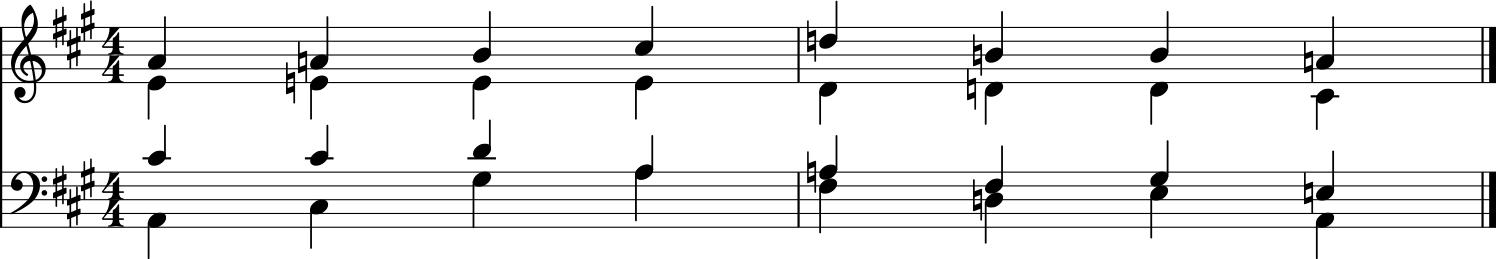

In [ ]:

from pprint import pprint
from music21 import *

key = 'A'
romans = 'I I6 V6/5 I IV6 ii6 V7 I'
num_chord = len(romans.split(' '))
chords = [ChordVar([f's{i}', f'a{i}', f't{i}', f'b{i}']) for i in range(num_chord)]
s, a, t, b = stream_vars = [StreamVar([f'{part}{i}' for i in range(num_chord)]) for part in ['s', 'a', 't', 'b']]




pitch_class_midi_rel = z3.And([PitchClassMidiRelation(pitch_var) for chord in chords for pitch_var in chord.pitches])
four_part_range = FourPartRange((s, a, t, b))
no_overlaps = z3.And([NoVoiceOverlap(chord_var) for chord_var in chords])
chord_eqs = z3.And([ChordEqRoman(chord_var, key, roman) for chord_var, roman in zip(chords, romans.split(' '))])


# More constraints
chord_specific = z3.And([DoubleRoot(chords[-1], key, 'I')])

no_crossing = z3.And([NoVoiceCrossing(a, b) for a, b in zip(chords, chords[1:])])
no_parallel_5th = z3.And([NoParallelFifth(a, b) for a, b in zip(chords, chords[1:])])
no_parallel_8ve = z3.And([NoParallelOctave(a, b) for a, b in zip(chords, chords[1:])])
smooth_voices = z3.And(SmoothVoice(s, 'M3'), SmoothVoice(a, 'P5'), SmoothVoice(t, 'P5'), SmoothVoice(b, 'P5'))
at_most_8ve_apart = z3.And([VoicesWithinInterval(upper, lower, 'P8') for upper, lower in zip(stream_vars[:-1], stream_vars[1:-1])])

solver = z3.Solver()
solver.add(pitch_class_midi_rel, four_part_range, no_overlaps, no_crossing, chord_eqs)
solver.add(chord_specific)
solver.add(no_parallel_5th)
solver.add(no_parallel_8ve)
solver.add(smooth_voices)
solver.add(PitchClassEq(chords[-1].soprano(), pitch.Pitch('A')))
# solver.add(PitchClassEq(chords[-2].soprano(), pitch.Pitch('G#')))
solver.add(at_most_8ve_apart)
solver.check()
model = solver.model()




import music21.chord as cord
import music21.note
import music21.stream
import music21.clef



def display_results(model):
    s_val, a_val, t_val, b_val = stream_vals = [stream.Voice() for _ in range(4)]

    key_sig = music21.key.KeySignature(Key(key).sharps)
    for stream_val, stream_var in zip(stream_vals, stream_vars):
        stream_val.keySignature = key_sig 
        for pitch_var in stream_var.pitches:
            n = note.Note(model[pitch_var.midi].as_long())
            stream_val.append(n)


    
    treble_part = stream.PartStaff([s_val, a_val])
    treble_part.clef = clef.TrebleClef()
    treble_part.keySignature = key_sig
    bass_part = stream.PartStaff([t_val, b_val])
    bass_part.clef = clef.BassClef()
    bass_part.keySignature = key_sig



    score = stream.Score([treble_part, bass_part])
    score.keySignature = key_sig
    score.show()
    score.show('midi')


print('====== Model ======')
# pprint(model)
print('\n====== Demo ======\n')
display_results(model)
